# Seal vs Sea lion Image Classification

#Installs and Imports

In [ ]:
#install fastai2
!pip install -Uqq fastbook wandb
import fastbook

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
#imports
from fastbook import *
from fastai.vision.widgets import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.tracker import SaveModelCallback

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from plotnine import *
import shutil
import wandb

import warnings
warnings.filterwarnings('ignore')

# Download images

Function for searching image (ฟังก์ชันนี้ return url ของแต่ละ image กลับมา)

In [4]:
def search_images_ddg(key,max_n=150):
     """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
        (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api)
     """
     url        = 'https://duckduckgo.com/'
     params     = {'q':key}
     res        = requests.post(url,data=params)
     searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
     if not searchObj: print('Token Parsing Failed !'); return
     requestUrl = url + 'i.js'
     headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'}
     params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
     urls       = []
     while True:
         try:
             res  = requests.get(requestUrl,headers=headers,params=params)
             data = json.loads(res.text)
             for obj in data['results']:
                 urls.append(obj['image'])
                 max_n = max_n - 1
                 if max_n < 1: return L(set(urls))     # dedupe
             if 'next' not in data: return L(set(urls))
             requestUrl = url + data['next']
         except:
             pass

สร้าง path ที่เอาไว้เก็บรูปภาพ

In [33]:
#get images for seal and sea lion
types = 'seal animal','sea lion'
path = Path('/content/gdrive/MyDrive/deep learning/seal or sea lion/images')

เช็คว่ามีpathนี้อยู่แล้วหรือไม่ (หากมีแปลว่าเราเคย download ไปแล้ว)

In [34]:
if not path.exists():
  print("images haven't downloaded yet")
else:
  print("images have already downloaded")

images haven't downloaded yet


download รูป 150รูป ในแต่ละ types

In [35]:
#loop to download 150 images for each types
if not path.exists():
    path.mkdir()
    for o in types:
        dest = (path/o)
        if Path(path/o).exists():
          continue
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(o, max_n=150)
        download_images(dest, urls=results)
        #results = search_images_bing(key, f'{o} bear')
        #download_images(dest, urls=results.attrgot('contentUrl'))

เช็คดูว่าเราdownloadรูปมาสำเร็จหรือไม่

In [36]:
#get filenames for downloaded images
fns = get_image_files(path)
fns

(#263) [Path('/content/gdrive/MyDrive/deep learning/seal or sea lion/images/seal animal/00000007.jpg'),Path('/content/gdrive/MyDrive/deep learning/seal or sea lion/images/seal animal/00000002.jpg'),Path('/content/gdrive/MyDrive/deep learning/seal or sea lion/images/seal animal/00000008.jpg'),Path('/content/gdrive/MyDrive/deep learning/seal or sea lion/images/seal animal/00000009.jpg'),Path('/content/gdrive/MyDrive/deep learning/seal or sea lion/images/seal animal/00000005.jpg'),Path('/content/gdrive/MyDrive/deep learning/seal or sea lion/images/seal animal/00000000.jpg'),Path('/content/gdrive/MyDrive/deep learning/seal or sea lion/images/seal animal/00000006.jpg'),Path('/content/gdrive/MyDrive/deep learning/seal or sea lion/images/seal animal/00000013.jpg'),Path('/content/gdrive/MyDrive/deep learning/seal or sea lion/images/seal animal/00000014.jpg'),Path('/content/gdrive/MyDrive/deep learning/seal or sea lion/images/seal animal/00000004.jpg')...]

เนื่องจากตอนเรา download รูปจาก internet มีโอกาสที่จะ download ไม่สำเร็จ เราจึงทำการลบรูปเหล่านั้นทิ้งไป (unlink)

In [ ]:
#verify if there's any non-images downloaded
failed = verify_images(fns)
failed.map(Path.unlink) #if yes, unlink them from the paths

# From Data to DataLoaders

ลองสร้าง dataloader มาก่อน แล้วลองดูรูป

In [46]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x - image; y - single class
    get_items=get_image_files, #get image
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #split ไปเป็น validation 20% และกำหนด seed ที่ random
    get_y=parent_label, #use parent folder as label
    item_tfms=Resize(128)
    )
dls = dblock.dataloaders(path)

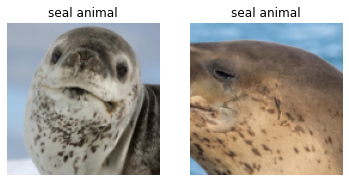

In [47]:
dls.train.show_batch(max_n=2, nrows=1)

ลองทำ Data Augmentation

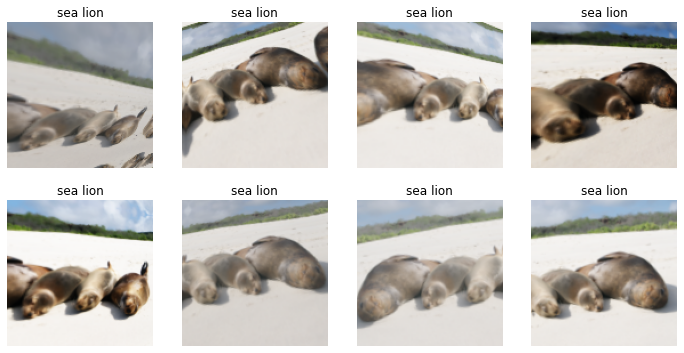

In [49]:
dblock = dblock.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dblock.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [51]:
dblock = dblock.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dblock.dataloaders(path, bs=64) #batch size = 64

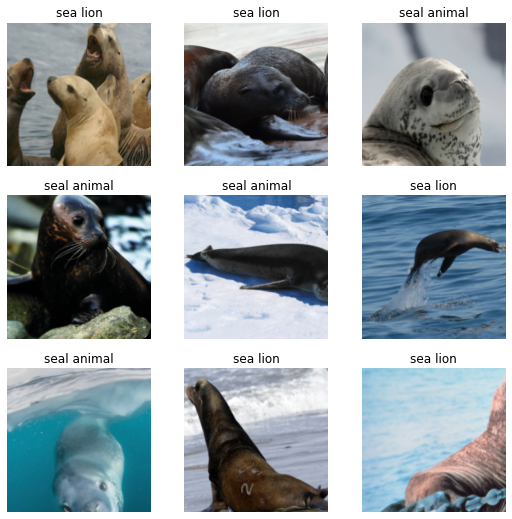

In [52]:
dls.train.show_batch(max_n=9, nrows=3)

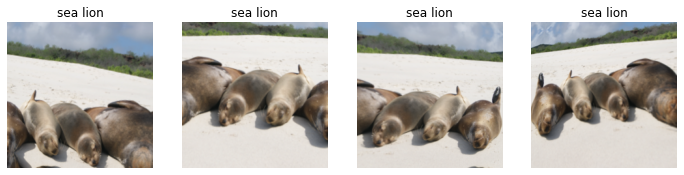

In [53]:
dls.train.show_batch(max_n=4, nrows=1, unique=True)

# Train model and Clean data

เราจะใช้ resnet34 ในการ train

In [54]:
learn = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy, 
                             Precision(), 
                             Recall(), 
                             F1Score()]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [55]:
learn.fine_tune(epochs=5,
          base_lr=1e-3, #max lr; when unfrozen base_lr/2
          freeze_epochs=1, #how many epochs to train frozen
          lr_mult=100, #train feature extractor with max lr at base_lr/lr_mult
          pct_start=0.2, #start decreasing lr at 
          div=5.0, #start at base_lr (max lr) / div
          cbs=[SaveModelCallback(monitor='f1_score')] #monitor f1 score and save best model
          )

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.322889,4.187538,0.442308,0.000000,0.000000,0.000000,01:33


Better model found at epoch 0 with f1_score value: 0.0.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.914540,1.993345,0.480769,1.000000,0.068966,0.129032,02:03
1,0.836109,0.871592,0.673077,0.928571,0.448276,0.604651,02:00
2,0.653534,0.629637,0.730769,0.941176,0.551724,0.695652,02:02
3,0.535218,0.538102,0.846154,1.000000,0.724138,0.840000,01:59
4,0.466928,0.474819,0.826923,0.916667,0.758621,0.830189,02:05


Better model found at epoch 0 with f1_score value: 0.12903225806451613.
Better model found at epoch 1 with f1_score value: 0.6046511627906977.
Better model found at epoch 2 with f1_score value: 0.6956521739130435.
Better model found at epoch 3 with f1_score value: 0.8400000000000001.


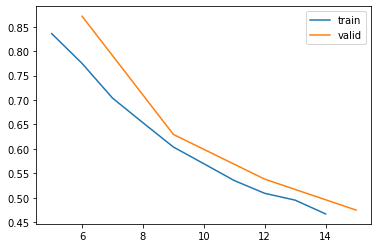

In [56]:
learn.recorder.plot_loss()

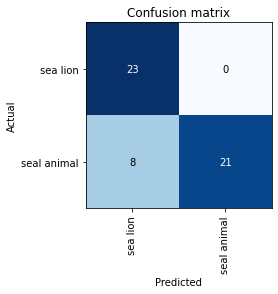

In [57]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

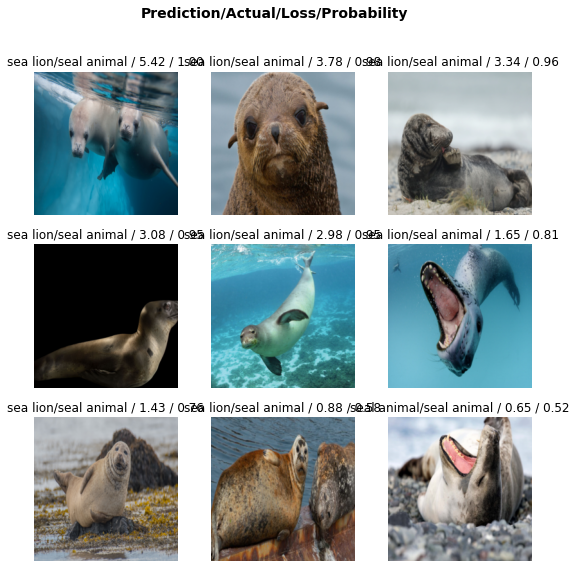

In [58]:
interp.plot_top_losses(9, nrows=3)

In [59]:
interp.print_classification_report()

              precision    recall  f1-score   support

    sea lion       0.74      1.00      0.85        23
 seal animal       1.00      0.72      0.84        29

    accuracy                           0.85        52
   macro avg       0.87      0.86      0.85        52
weighted avg       0.89      0.85      0.85        52



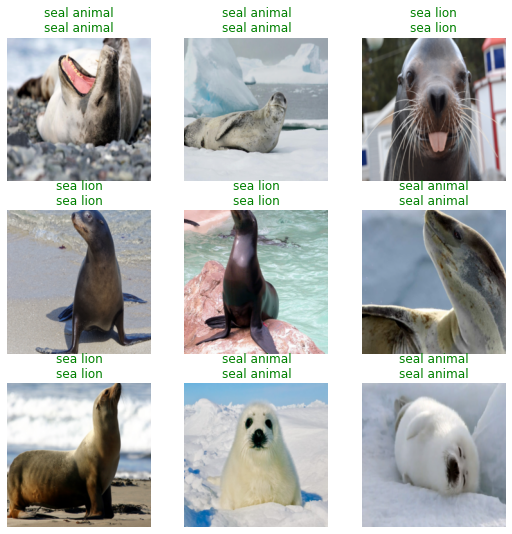

In [60]:
learn.show_results()

# Turning model to Application

Export learner ,fastai will save a file called "export.pkl":

In [61]:
learn.export()

In [65]:
path = Path('/content/gdrive/MyDrive/deep learning/seal or sea lion')
path.ls(file_exts='.pkl')

(#1) [Path('/content/gdrive/MyDrive/deep learning/seal or sea lion/export.pkl')]

Load learner from export file

In [66]:
learn_inf = load_learner(path/'export.pkl')

สร้าง widget สำหรับ output

In [79]:
out_pl = widgets.Output()

สร้าง widget แสดง prediction

In [80]:
lbl_pred = widgets.Label()

ฟังก์ชันสำหรับการทำงานเมื่อปุ่มถูกคลิก

In [83]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run = widgets.Button(description='Classify Seal or Sea Lion')
btn_run.on_click(on_click_classify)
btn_upload = widgets.FileUpload()

In [84]:
VBox([widgets.Label('Select Seal or Sea Lion image to predict'), 
      btn_upload, btn_run, out_pl, lbl_pred])